In [1]:
import pymysql.cursors
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
host = 'den1.mysql6.gear.host'
db = 'situation'
usr = 'situation'
psword = input()

# Connect to the database
connection = pymysql.connect(host=host, user=usr, password=psword, database=db, cursorclass=pymysql.cursors.DictCursor)

In [3]:
sql1 = "SELECT * FROM situation.i9_moleculeproperties"
sql2 = "SELECT * FROM situation.i9_properties"

with connection.cursor() as cursor:
    cursor.execute(sql1)
    ret = cursor.fetchall()
    molecule_prop_df = pd.DataFrame(ret)

with connection.cursor() as cursor:
    cursor.execute(sql2)
    ret = cursor.fetchall()
    properties_df = pd.DataFrame(ret)

merged_df = pd.merge(molecule_prop_df, properties_df, on="PropertyID")
merged_df.head(10)

,MoleculePropertyID,MoleculeID,PropertyID,Value,PropertyName,UnitMeasurement
0,1,14,1,151.16,Molecular Weight,g/mol
1,2,14,2,1,Polarity,None
2,3,14,3,1,Solubility,None
3,4,14,4,1,Melting Point,°C
4,5,14,5,100.00,Boiling Point,°C
5,6,14,6,1,Density,g/cm^3
6,7,14,7,1,Reactivity,None
7,15,15,1,151.16,Molecular Weight,g/mol
8,16,15,2,2,Polarity,None
9,17,15,3,1,Solubility,None


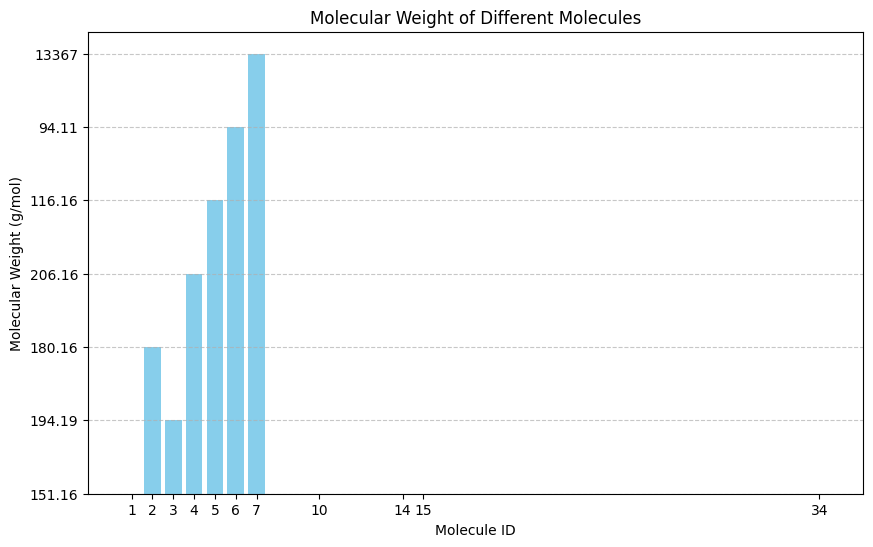

In [4]:
# Filter for Molecular Weight data
molecular_weight_df = merged_df[merged_df["PropertyName"] == "Molecular Weight"]

# Plot Molecular Weight for each MoleculeID
plt.figure(figsize=(10, 6))
plt.bar(molecular_weight_df["MoleculeID"], molecular_weight_df["Value"], color='skyblue')
plt.xlabel('Molecule ID')
plt.ylabel('Molecular Weight (g/mol)')
plt.title('Molecular Weight of Different Molecules')
plt.xticks(molecular_weight_df["MoleculeID"])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [5]:
pivot_df = merged_df.pivot(index='MoleculeID', columns='PropertyName', values='Value')
pivot_df.columns.name = None
pivot_df

,Boiling Point,Density,Melting Point,Molecular Weight,Polarity,Reactivity,Solubility
MoleculeID,,,,,,,
1,500,1.3,168,151.16,0,NaN,14000 mg/L in water
2,140,1.4,135,180.16,1,NaN,4600 mg/L in water
3,178,1.23,311,194.19,1,NaN,2.16 * 10^4 mg/L in water (25°C)
4,157,NaN,76,206.16,NaN,NaN,21 mg/L in water (25 °C)
5,126,0.88,-78,116.16,NaN,NaN,8.33*10^3 mg/L in water (25 °C)
6,181.8,1.06,40.9,94.11,1,NaN,82.8 mg/mL (25 °C)
7,NaN,NaN,NaN,13367,2,NaN,NaN
10,78.00,1,1,151.16,2,1,1
14,100.00,1,1,151.16,1,1,1


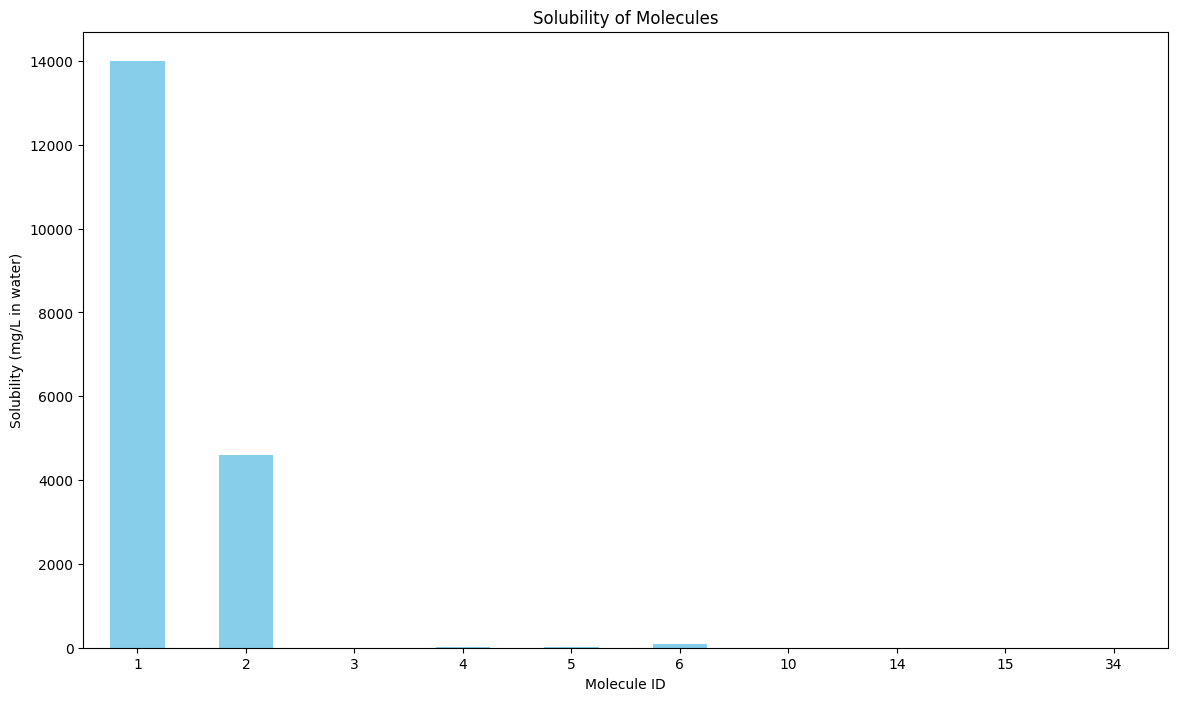

In [6]:
df = pivot_df
# Correcting the issue with handling solubility data
def parse_solubility(value):
    if isinstance(value, str):
        return float(value.split(' ')[0].replace('*10^4', '0000').replace('*10^3', '000').replace('mg/mL', '000').replace('mg/L', ''))
    return value

# Apply the parsing function to the Solubility column
df['Parsed Solubility'] = df['Solubility'].apply(parse_solubility)

# Visualizing Solubility separately as a bar plot with parsed numerical values
plt.figure(figsize=(14, 8))
df['Parsed Solubility'].dropna().plot(kind='bar', color='skyblue')
plt.title('Solubility of Molecules')
plt.xlabel('Molecule ID')
plt.ylabel('Solubility (mg/L in water)')
plt.xticks(rotation=0)
plt.show()

,Boiling Point,Density,Melting Point,Molecular Weight,Polarity,Reactivity,Solubility,Parsed Solubility
MoleculeID,,,,,,,,
1,500.0,1.30,168.0,151.16,0,NaN,14000 mg/L in water,14000.00
2,140.0,1.40,135.0,180.16,1,NaN,4600 mg/L in water,4600.00
3,178.0,1.23,311.0,194.19,1,NaN,2.16 * 10^4 mg/L in water (25°C),2.16
4,157.0,NaN,76.0,206.16,NaN,NaN,21 mg/L in water (25 °C),21.00
5,126.0,0.88,-78.0,116.16,NaN,NaN,8.33*10^3 mg/L in water (25 °C),8.33
6,181.8,1.06,40.9,94.11,1,NaN,82.8 mg/mL (25 °C),82.80
7,NaN,NaN,NaN,13367.00,2,NaN,NaN,NaN
10,78.0,1.00,1.0,151.16,2,1,1,1.00
14,100.0,1.00,1.0,151.16,1,1,1,1.00


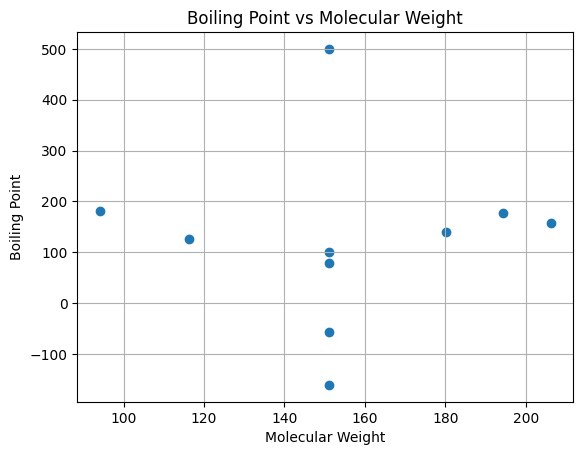

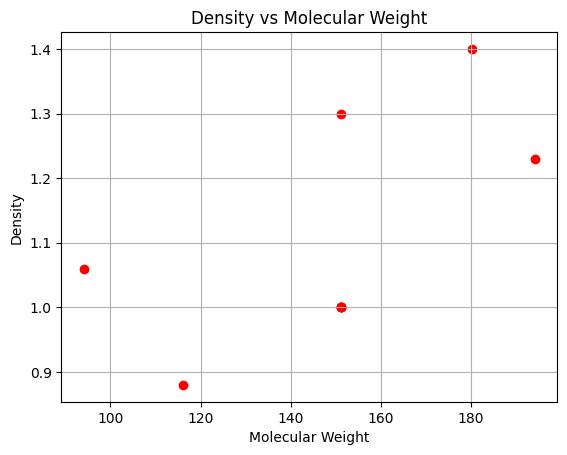

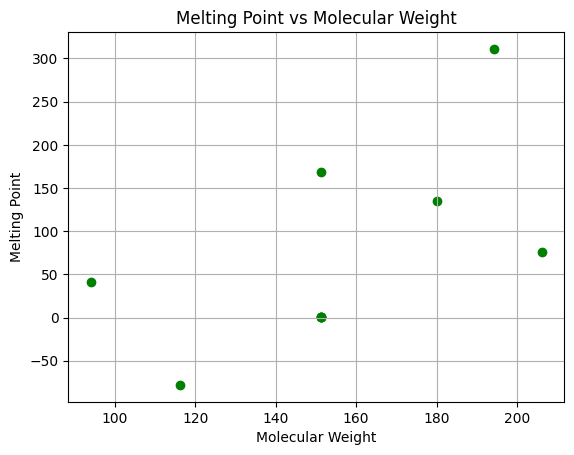

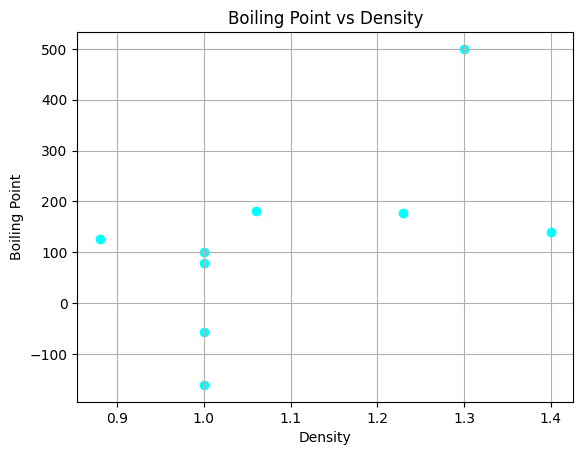

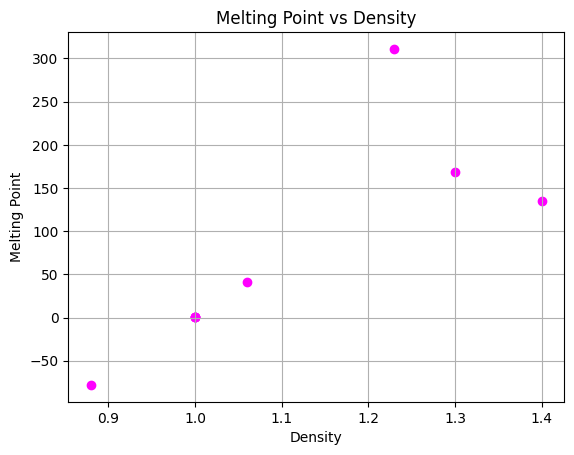

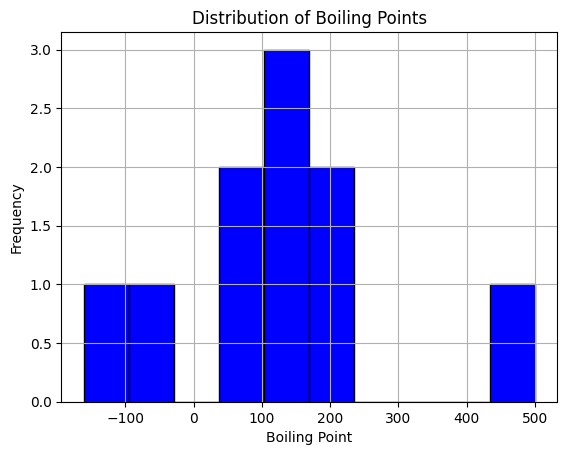

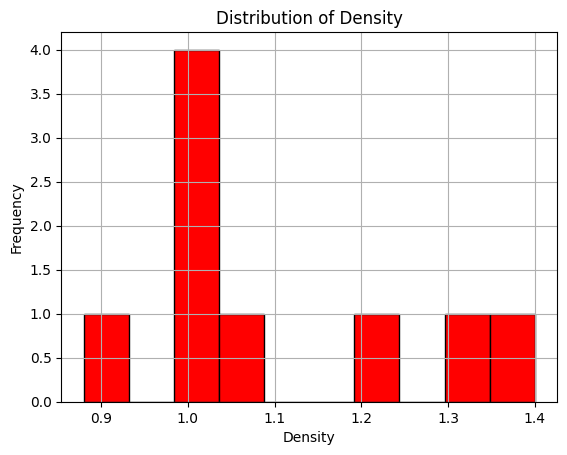

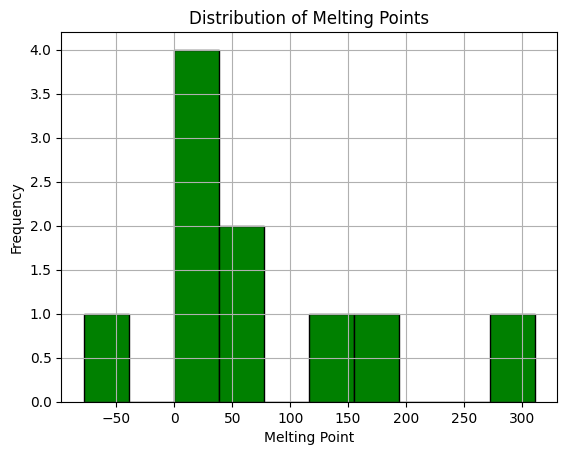

In [8]:
df = pivot_df
# Convert the Boiling Point, Density, Melting Point, and Molecular Weight columns to numeric
df['Boiling Point'] = pd.to_numeric(df['Boiling Point'], errors='coerce')
df['Density'] = pd.to_numeric(df['Density'], errors='coerce')
df['Melting Point'] = pd.to_numeric(df['Melting Point'], errors='coerce')
df['Molecular Weight'] = pd.to_numeric(df['Molecular Weight'], errors='coerce')
display(df)


# Plot 1: Boiling Point vs Molecular Weight
plt.figure()
plt.scatter(df['Molecular Weight'], df['Boiling Point'])
plt.title('Boiling Point vs Molecular Weight')
plt.xlabel('Molecular Weight')
plt.ylabel('Boiling Point')
plt.grid(True)
plt.show()

# Plot 2: Density vs Molecular Weight
plt.figure()
plt.scatter(df['Molecular Weight'], df['Density'], color='red')
plt.title('Density vs Molecular Weight')
plt.xlabel('Molecular Weight')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Plot 3: Melting Point vs Molecular Weight
plt.figure()
plt.scatter(df['Molecular Weight'], df['Melting Point'], color='green')
plt.title('Melting Point vs Molecular Weight')
plt.xlabel('Molecular Weight')
plt.ylabel('Melting Point')
plt.grid(True)
plt.show()

# Plot 4: Boiling Point vs Density
plt.figure()
plt.scatter(df['Density'], df['Boiling Point'], color='cyan')
plt.title('Boiling Point vs Density')
plt.xlabel('Density')
plt.ylabel('Boiling Point')
plt.grid(True)
plt.show()

# Plot 5: Melting Point vs Density
plt.figure()
plt.scatter(df['Density'], df['Melting Point'], color='magenta')
plt.title('Melting Point vs Density')
plt.xlabel('Density')
plt.ylabel('Melting Point')
plt.grid(True)
plt.show()

# Plot 6: Polarity vs Molecular Weight
#plt.figure()
#plt.scatter(df['Molecular Weight'], df['Polarity'], color='yellow')
#plt.title('Polarity vs Molecular Weight')
#plt.xlabel('Molecular Weight')
#plt.ylabel('Polarity')
#plt.grid(True)
#plt.show()

# Plot 7: Boiling Point Distribution
plt.figure()
df['Boiling Point'].plot(kind='hist', bins=10, color='blue', edgecolor='black')
plt.title('Distribution of Boiling Points')
plt.xlabel('Boiling Point')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot 8: Density Distribution
plt.figure()
df['Density'].plot(kind='hist', bins=10, color='red', edgecolor='black')
plt.title('Distribution of Density')
plt.xlabel('Density')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot 9: Melting Point Distribution
plt.figure()
df['Melting Point'].plot(kind='hist', bins=10, color='green', edgecolor='black')
plt.title('Distribution of Melting Points')
plt.xlabel('Melting Point')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot 10: Polarity Distribution
#plt.figure()
#df['Polarity'].plot(kind='hist', bins=10, color='orange', edgecolor='black')
#plt.title('Distribution of Polarity')
#plt.xlabel('Polarity')
#plt.ylabel('Frequency')
#plt.grid(True)
#plt.show()

In [ ]:
display(df)

,Boiling Point,Density,Melting Point,Molecular Weight,Polarity,Reactivity,Solubility,Parsed Solubility
MoleculeID,,,,,,,,
1,500.0,1.30,168.0,151.16,0,NaN,14000 mg/L in water,14000.00
2,140.0,1.40,135.0,180.16,1,NaN,4600 mg/L in water,4600.00
3,178.0,1.23,311.0,194.19,1,NaN,2.16 * 10^4 mg/L in water (25°C),2.16
4,157.0,NaN,76.0,206.16,NaN,NaN,21 mg/L in water (25 °C),21.00
5,126.0,0.88,-78.0,116.16,NaN,NaN,8.33*10^3 mg/L in water (25 °C),8.33
6,181.8,1.06,40.9,94.11,1,NaN,82.8 mg/mL (25 °C),82.80
7,NaN,NaN,NaN,13367.00,2,NaN,NaN,NaN
10,78.0,1.00,1.0,151.16,2,1,1,1.00
14,100.0,1.00,1.0,151.16,1,1,1,1.00


In [ ]:
data = {
    "Boiling Point": [500, 140, 178, 157, 126, 181.8, None, 78.00, 100.00, -161.00, -57.00],
    "Density": [1.3, 1.4, 1.23, None, 0.88, 1.06, None, 1, 1, 1, 1],
    "Melting Point": [168, 135, 311, 76, -78, 40.9, None, 1, 1, 1, 1],
    "Molecular Weight": [151.16, 180.16, 194.19, 206.16, 116.16, 94.11, 13367, 151.16, 151.16, 151.16, 151.16],
    "Polarity": [0, 1, 1, None, None, 1, 2, 2, 1, 2, 2],
    "Reactivity": [None, None, None, None, None, None, None, 1, 1, 1, 1],
    "Solubility": ["14000 mg/L in water", "4600 mg/L in water", "2.16 * 10^4 mg/L in water (25°C)", "21 mg/L in water (25 °C)", "8.33*10^3 mg/L in water (25 °C)", "82.8 mg/mL (25 °C)", None, 1, 1, 1, 1]
}

df = pd.DataFrame(data, index=[1, 2, 3, 4, 5, 6, 7, 10, 14, 15, 34])

# Convert the Boiling Point, Density, Melting Point, and Molecular Weight columns to numeric
df['Boiling Point'] = pd.to_numeric(df['Boiling Point'], errors='coerce')
df['Density'] = pd.to_numeric(df['Density'], errors='coerce')
df['Melting Point'] = pd.to_numeric(df['Melting Point'], errors='coerce')
df['Molecular Weight'] = pd.to_numeric(df['Molecular Weight'], errors='coerce')

display(df)

,Boiling Point,Density,Melting Point,Molecular Weight,Polarity,Reactivity,Solubility
1,500.0,1.30,168.0,151.16,0.0,NaN,14000 mg/L in water
2,140.0,1.40,135.0,180.16,1.0,NaN,4600 mg/L in water
3,178.0,1.23,311.0,194.19,1.0,NaN,2.16 * 10^4 mg/L in water (25°C)
4,157.0,NaN,76.0,206.16,NaN,NaN,21 mg/L in water (25 °C)
5,126.0,0.88,-78.0,116.16,NaN,NaN,8.33*10^3 mg/L in water (25 °C)
6,181.8,1.06,40.9,94.11,1.0,NaN,82.8 mg/mL (25 °C)
7,NaN,NaN,NaN,13367.00,2.0,NaN,None
10,78.0,1.00,1.0,151.16,2.0,1.0,1
14,100.0,1.00,1.0,151.16,1.0,1.0,1
15,-161.0,1.00,1.0,151.16,2.0,1.0,1
